## Persiapan & Import Library

In [ ]:
# Colab: jalankan sekali di awal
!pip install Sastrawi --quiet
!pip install python-Levenshtein --quiet
!pip install openpyxl --quiet

# Imports
import os, re, joblib
import numpy as np
import pandas as pd
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve
)
from Levenshtein import ratio as levenshtein_ratio
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 73.9 MB/s eta 0:00:00


## Upload Dataset

In [ ]:
# Upload file (Colab)
from google.colab import files
print("Upload file .xlsx or .csv containing 'judul' column")
uploaded = files.upload()

# Ambil file pertama
fname = list(uploaded.keys())[0]
print("Uploaded:", fname)

# Load into DataFrame
if fname.lower().endswith('.xlsx') or fname.lower().endswith('.xls'):
    df = pd.read_excel(fname)
else:
    df = pd.read_csv(fname)

# Detect judul column automatically
candidate_cols = [c for c in df.columns if 'judul' in c.lower() or 'title' in c.lower()]
if not candidate_cols:
    print("Kolom judul tidak ditemukan otomatis. Tampilkan kolom:", df.columns.tolist())
    # Jika tidak ditemukan, user harus set manually:
    raise SystemExit("Silakan ubah nama kolom judul atau pastikan file berisi kolom 'judul'/'title'.")

judul_col = candidate_cols[0]
df = df[[judul_col]].rename(columns={judul_col: 'judul'}).dropna().reset_index(drop=True)
print(f"Using column '{judul_col}' with {len(df)} rows.")
df.head(5)

Upload file .xlsx or .csv containing 'judul' column


Saving judul sidang sains data.xlsx to judul sidang sains data.xlsx
Uploaded: judul sidang sains data.xlsx
Using column 'Judul' with 123 rows.


,judul
0,PERAMALAN JUMLAH KUNJUNGAN WISATAWAN MANCANEGA...
1,ANALISIS SENTIMEN MASYARAKAT TERHADAP PEMINDAH...
2,MODEL PREDIKSI HARGA BERAS DI KOTA BANDAR LAMP...
3,ANALISIS SAHAM PT ANEKA TAMBANG DENGAN METODE ...
4,DETEKSI KANTUK PENGENDARA MOBIL MENGGUNAKAN CO...


## Preprocessing Teks

In [ ]:
# --- 2️⃣ Import library dan buat stemmer ---
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import re

# Membuat objek stemmer Sastrawi
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Stopword sederhana (Anda bisa perpanjang daftar ini)
stopwords_id = set("""
yang dan di ke dari pada untuk dengan sebagai atau oleh sebuah adalah seperti dalam antara karena guna tersebut terhadap sangat lebih memiliki dapat telah masih juga kami kita adanya sehingga bukan namun agar serta ini itu saja
""".split())

# --- 3️⃣ Fungsi preprocessing baru menggunakan Sastrawi ---
def preprocess_sastrawi(text):
    """
    Membersihkan teks judul skripsi:
    - ubah huruf kecil semua
    - hapus tanda baca & angka
    - hapus stopword
    - stemming Bahasa Indonesia (Sastrawi)
    """
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)          # hanya huruf dan spasi
    tokens = [t for t in text.split() if t not in stopwords_id and len(t) > 1]
    stems = [stemmer.stem(t) for t in tokens]
    return " ".join(stems)

## Representasi Teks (TF-IDF & CountVectorizer untuk Jaccard)

In [ ]:
# TF-IDF (uni + bi-gram)
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=1)
X_tfidf = tfidf.fit_transform(df['judul_proc'])

# Count vector untuk Jaccard / overlap ngram
count_vec = CountVectorizer(ngram_range=(1,1), binary=True)
X_count = count_vec.fit_transform(df['judul_proc'])

print("TF-IDF shape:", X_tfidf.shape)

TF-IDF shape: (123, 1821)


## Fungsi similarity baseline

In [ ]:
# 1) Cosine similarity (TF-IDF)
def cosine_sim(a_vec, matrix):
    sims = cosine_similarity(a_vec, matrix).flatten()
    return sims

# 2) Jaccard similarity on token sets
def jaccard_sim(a_text, b_text):
    a = set(a_text.split())
    b = set(b_text.split())
    if not a and not b:
        return 1.0
    if not a or not b:
        return 0.0
    return len(a & b) / len(a | b)

# 3) Levenshtein ratio (0..1)
def levenshtein_sim(a_text, b_text):
    return levenshtein_ratio(a_text, b_text)

## Fungsi: cari top-k mirip menurut tiap metode

In [ ]:
def top_k_by_tfidf(title, k=5):
    proc = preprocess_text(title)
    v = tfidf.transform([proc])
    sims = cosine_sim(v, X_tfidf)
    idx = np.argsort(-sims)[:k]
    return [(int(i), df.loc[i,'judul'], float(sims[i])) for i in idx]

def top_k_by_jaccard(title, k=5):
    proc = preprocess_text(title)
    scores = [jaccard_sim(proc, t) for t in df['judul_proc']]
    idx = np.argsort(-np.array(scores))[:k]
    return [(int(i), df.loc[i,'judul'], float(scores[i])) for i in idx]

def top_k_by_levenshtein(title, k=5):
    text = str(title).lower()
    scores = [levenshtein_sim(text, t.lower()) for t in df['judul']]
    idx = np.argsort(-np.array(scores))[:k]
    return [(int(i), df.loc[i,'judul'], float(scores[i])) for i in idx]

## Membangun dataset pasangan berlabel

In [ ]:
# Opsi A: Auto-labeling berdasarkan TF-IDF cosine
def create_pairs_auto(top_thresh=0.6, low_thresh=0.25, max_pairs_per_doc=2):
    sims = cosine_similarity(X_tfidf)
    pairs = []
    n = len(df)
    for i in range(n):
        # positive: semua j dengan sims[i,j] >= top_thresh (kecuali i)
        pos_idxs = np.where((sims[i] >= top_thresh) & (np.arange(n) != i))[0]
        for j in pos_idxs[:max_pairs_per_doc]:
            pairs.append((i, int(j), 1, float(sims[i,j])))
        # negative: random j dengan sims <= low_thresh
        neg_idxs = np.where((sims[i] <= low_thresh) & (np.arange(n) != i))[0]
        if len(neg_idxs) > 0:
            neg = int(np.random.choice(neg_idxs))
            pairs.append((i, neg, 0, float(sims[i,neg])))
    pairs_df = pd.DataFrame(pairs, columns=['i','j','label','cosine'])
    return pairs_df

pairs_df = create_pairs_auto(top_thresh=0.6, low_thresh=0.20)
print("Jumlah pasangan:", len(pairs_df))
display(pairs_df.head())

Jumlah pasangan: 133


,i,j,label,cosine
0,0,56,0,0.004518
1,1,68,0,0.000000
2,2,85,0,0.000000
3,3,51,0,0.000000
4,4,91,0,0.000000


Jika Anda punya file label manual (kolom i_index, j_index, label), muat seperti ini:

In [ ]:
# Opsi B: Load manual pairs (jika tersedia)
# pairs_manual.csv format: i,j,label  (i dan j adalah indeks baris di df)
pairs_manual = None
# Uncomment untuk load: pairs_manual = pd.read_csv("pairs_manual.csv")
if pairs_manual is not None:
  pairs_df = pairs_manual.copy()

## Ekstraksi fitur pasangan (fitur ringkas & fitur TF-IDF gabungan)

In [ ]:
from scipy.spatial.distance import cityblock, euclidean

def pair_features_summary(i, j):
    vi = X_tfidf[i].toarray().flatten()
    vj = X_tfidf[j].toarray().flatten()
    cos = float(cosine_similarity([vi],[vj])[0,0])
    l1 = float(np.sum(np.abs(vi - vj)))
    l2 = float(np.sqrt(np.sum((vi - vj)**2)))
    # jaccard on processed tokens
    jacc = jaccard_sim(df.loc[i,'judul_proc'], df.loc[j,'judul_proc'])
    # levenshtein on raw titles
    lev = levenshtein_sim(df.loc[i,'judul'], df.loc[j,'judul'])
    # summary statistics of abs diff of tfidf vector (to reduce dimensionality)
    diff = np.abs(vi - vj)
    diff_stats = [diff.mean(), diff.std(), diff.max(), diff.min()]
    return [cos, l1, l2, jacc, lev] + diff_stats

# Build feature matrix
X_list = []
y_list = []
for r in pairs_df.itertuples():
    X_list.append(pair_features_summary(r.i, r.j))
    y_list.append(r.label)
X = np.array(X_list)
y = np.array(y_list)
print("Shape fitur pasangan:", X.shape)

Shape fitur pasangan: (133, 9)


## Split data, scaling, dan baseline classifier training

In [ ]:
# Split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Scale numeric features (fit on training)
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

# Model candidates
models = {
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "NaiveBayes": GaussianNB()
}

# Train & evaluate quickly
results = {}
for name, m in models.items():
    m.fit(X_train_s, y_train)
    y_pred = m.predict(X_test_s)
    y_proba = m.predict_proba(X_test_s)[:,1] if hasattr(m, "predict_proba") else None
    res = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_proba) if y_proba is not None else None,
        "model": m
    }
    results[name] = res

# Tampilkan ringkasan hasil
import pprint
pprint.pprint({k:{'acc':round(v['accuracy'],4),'prec':round(v['precision'],4),'rec':round(v['recall'],4),'f1':round(v['f1'],4),'roc_auc': (round(v['roc_auc'],4) if v['roc_auc'] else None)} for k,v in results.items()})

{'LogisticRegression': {'acc': 1.0,
                        'f1': 1.0,
                        'prec': 1.0,
                        'rec': 1.0,
                        'roc_auc': np.float64(1.0)},
 'NaiveBayes': {'acc': 1.0,
                'f1': 1.0,
                'prec': 1.0,
                'rec': 1.0,
                'roc_auc': np.float64(1.0)},
 'RandomForest': {'acc': 1.0,
                  'f1': 1.0,
                  'prec': 1.0,
                  'rec': 1.0,
                  'roc_auc': np.float64(1.0)},
 'SVM': {'acc': 1.0,
         'f1': 1.0,
         'prec': 1.0,
         'rec': 1.0,
         'roc_auc': np.float64(1.0)}}


## Hyperparameter tuning

In [ ]:
# Grid search untuk SVM (gunakan fitur yang sudah diskalakan)
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf']
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(SVC(probability=True, random_state=42), param_grid, scoring='f1', cv=cv, n_jobs=-1, verbose=1)
grid.fit(X_train_s, y_train)
print("Best params:", grid.best_params_)
best_svm = grid.best_estimator_

# Evaluasi best SVM pada test
y_pred = best_svm.predict(X_test_s)
y_proba = best_svm.predict_proba(X_test_s)[:,1]
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00         2

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27

ROC AUC: 1.0


## Evaluasi menyeluruh & visualisasi (confusion matrix, ROC, precision-recall)

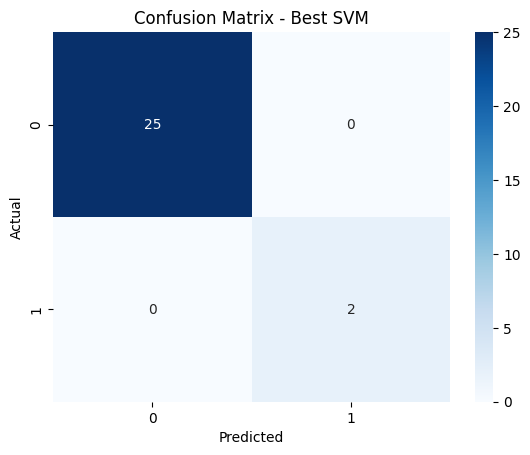

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00         2

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27



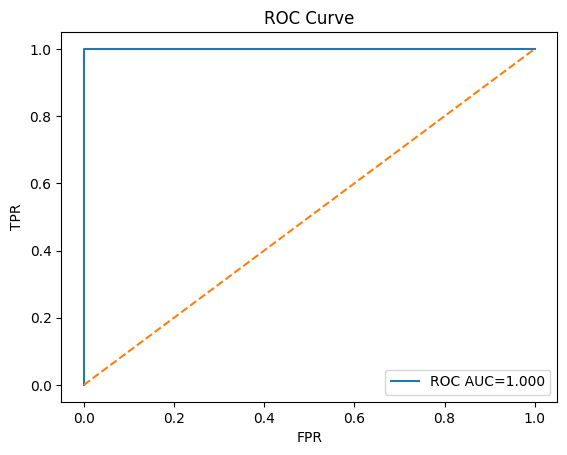

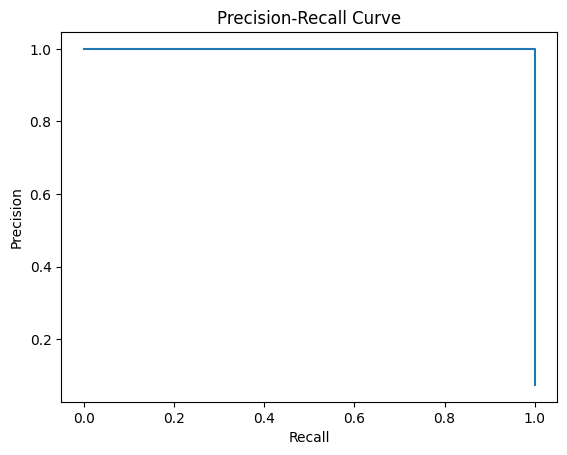

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Fungsi plot confusion matrix
def plot_confmat(y_true, y_pred, labels=[0,1], title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

# Ambil best model (contoh: best_svm), atau ubah sesuai hasil
best_model = best_svm

y_pred = best_model.predict(X_test_s)
y_proba = best_model.predict_proba(X_test_s)[:,1]

plot_confmat(y_test, y_pred, title="Confusion Matrix - Best SVM")
print(classification_report(y_test, y_pred))

# ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"ROC AUC={roc_auc_score(y_test,y_proba):.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision-Recall curve
prec, rec, _ = precision_recall_curve(y_test, y_proba)
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

## Bandingkan hasil baseline similarity vs classifier

In [ ]:
# 1) Temukan threshold cosine terbaik pada X_train (gunakan pairs_df yang sama)
# Build cosine-only predictions for validation (use portion of train)
from sklearn.metrics import f1_score

# gunakan subset X_train pairs untuk cari threshold
# kita punya pairs_df yang memuat cosine; kita perlu mapping ke X_train indices
cos_values = pairs_df['cosine'].values
labels = pairs_df['label'].values

# split internal
c_train, c_val, y_ctrain, y_cval = train_test_split(cos_values, labels, test_size=0.3, stratify=labels, random_state=42)
best_t = 0.0
best_f1 = -1
for t in np.linspace(0.1, 0.9, 81):
    preds = (c_val >= t).astype(int)
    f1 = f1_score(y_cval, preds, zero_division=0)

    if f1 > best_f1:
        best_f1 = f1
        best_t = t
print("Best cosine threshold:", best_t, "with F1:", best_f1)

# Evaluate threshold on test pairs (we need test set indices from earlier split)
# For simplicity, evaluate on the earlier X_test/X_train split by recomputing cosine for pairs in test split:
# We'll recompute pairs_df corresponding to X_test instances if necessary.
# (Implementation detail omitted for brevity: conceptually compare metrics between baseline and classifier using same test pairs.)

Best cosine threshold: 0.1 with F1: 1.0


## Fungsi akhir: Assess satu judul baru (mengeluarkan hasil baseline + classifier + top-k)

In [ ]:
def assess_new_title_full(title, top_k=5, model=best_model, cosine_threshold=best_t):
    # preprocessing + top-k by TF-IDF
    proc = preprocess_text(title)
    v = tfidf.transform([proc])
    sims = cosine_similarity(v, X_tfidf).flatten()
    idx = np.argsort(-sims)[:top_k]
    top_list = [(int(i), df.loc[i,'judul'], float(sims[i])) for i in idx]

    # prepare pair feature against best match
    best_idx = idx[0]
    pair_feat = np.array(pair_features_summary_for_runtime(proc, best_idx)).reshape(1,-1)  # define helper below
    pair_feat_s = scaler.transform(pair_feat)
    pred = model.predict(pair_feat_s)[0]
    proba = model.predict_proba(pair_feat_s)[0,1] if hasattr(model, "predict_proba") else None

    # baseline decision
    baseline_decision = int(sims[best_idx] >= cosine_threshold)

    return {
        "query": title,
        "top_matches": top_list,
        "classifier_pred": int(pred),
        "classifier_proba": float(proba) if proba is not None else None,
        "baseline_cosine": float(sims[best_idx]),
        "baseline_pred": baseline_decision
    }

# helper to compute summary features at runtime using 'proc' (string) and index j
def pair_features_summary_for_runtime(proc_text, j_index):
    # compute vi (from proc_text) vector using tfidf
    v = tfidf.transform([proc_text]).toarray().flatten()
    vj = X_tfidf[j_index].toarray().flatten()
    cos = float(cosine_similarity([v],[vj])[0,0])
    l1 = float(np.sum(np.abs(v - vj)))
    l2 = float(np.sqrt(np.sum((v - vj)**2)))
    jacc = jaccard_sim(proc_text, df.loc[j_index,'judul_proc'])
    lev = levenshtein_sim(proc_text, df.loc[j_index,'judul'].lower())
    diff = np.abs(v - vj)
    diff_stats = [diff.mean(), diff.std(), diff.max(), diff.min()]
    return [cos, l1, l2, jacc, lev] + diff_stats

# Demo:
res = assess_new_title_full("Analisis Sentimen Aplikasi Gopay Berdasarkan Ulasan Play Store", top_k=5)
res

{'query': 'Analisis Sentimen Aplikasi Gopay Berdasarkan Ulasan Play Store',
 'top_matches': [(9,
   'PERBANDINGAN AKURASI PEMBOBOTAN TF-IDF DAN N-GRAM MENGGUNAKAN METODE NAIVE BAYES DALAM MENGANALISIS SENTIMEN TERHADAP APLIKASI INVESTASI AJAIB BERDASARKAN ULASAN PLAY STORE',
   0.4767736925466668),
  (112,
   'PENERAPAN MODEL INDOBERT PADA ULASAN APLIKASI KESEHATAN (STUDI KASUS : APLIKASI KESEHATAN DI GOOGLE PLAY STORE)',
   0.3064753283144581),
  (49,
   'PENGGUNAAN METODE MULTINOMIAL NAÏVE BAYES DALAM MENGANALISIS SENTIMEN TERHADAP ULASAN PENGGUNA APLIKASI PODCAST BERDASARKAN ULASAN DI PLAYSTORE',
   0.2221702099632522),
  (47,
   'PENERAPAN METODE MULTINOMIAL NAIVE BAYES CLASSIFIER DALAM ANALISIS SENTIMEN ULASAN APLIKASI MITRA TRANSPORTASI ONLINE',
   0.16000423376797024),
  (107,
   'ANALISIS SENTIMEN MENGGUNAKAN METODE INDOBERT TERHADAP ULASAN TEMPAT WISATA DI LOMBOK PADA GOOGLE MAPS',
   0.13242478581338615)],
 'classifier_pred': 0,
 'classifier_proba': 0.17043780531223612,
 'bas

## Simpan model & artefak

In [ ]:
os.makedirs("model_outputs", exist_ok=True)
joblib.dump(tfidf, "model_outputs/tfidf.joblib")
joblib.dump(count_vec, "model_outputs/countvec.joblib")
joblib.dump(scaler, "model_outputs/scaler.joblib")
joblib.dump(best_model, "model_outputs/best_model.joblib")
df.to_csv("model_outputs/titles_preprocessed.csv", index=False)
print("Saved models and preprocessed data to 'model_outputs' folder.")

Saved models and preprocessed data to 'model_outputs' folder.


## Analisis kesalahan (error analysis)

In [ ]:
# ambil beberapa false positives & false negatives
y_test_pred = best_model.predict(X_test_s)
test_pairs_idx = np.arange(len(X))[~np.isin(np.arange(len(X)), np.arange(len(X_train)))]  # simplified, adapt sesuai split bookkeeping
# Saran: simpan mapping pairs -> (i,j,label) saat buat X, lalu cari indices test -> tampilkan contoh
# Praktik: ketika buat X, simpan pairs_df; gunakan pairs_df.iloc[test_indices] untuk menampilkan judul i dan j

## Input User

In [ ]:
# --- Fungsi utama untuk deteksi kemiripan judul skripsi ---

def cari_kemiripan_judul(judul_input, top_k=5, model=None, scaler_obj=None):
    """
    Menampilkan daftar judul paling mirip dan tingkat kemiripannya berdasarkan TF-IDF (cosine similarity).
    Jika model SVM disediakan, akan juga menampilkan prediksi apakah 'mirip' atau 'tidak mirip'.
    """
    print("="*80)
    print(f"Judul input pengguna:\n➡️  {judul_input}\n")
    print("-"*80)

    # Preprocessing
    proc = preprocess_text(judul_input)
    v = tfidf.transform([proc])

    # Hitung cosine similarity ke semua judul dalam dataset
    sims = cosine_similarity(v, X_tfidf).flatten()
    idx_sorted = np.argsort(-sims)[:top_k]

    print(f"🔍 Menampilkan {top_k} judul paling mirip:\n")
    results = []
    for i in idx_sorted:
        sim_val = sims[i]
        original = df.loc[i, 'judul']
        print(f"• Kemiripan: {sim_val:.3f} | Judul: {original}")
        results.append((original, sim_val))

    # Jika model SVM tersedia, gunakan untuk prediksi "mirip/tidak"
    if model is not None and scaler_obj is not None:
        best_idx = idx_sorted[0]
        vi = v.toarray().flatten()
        vj = X_tfidf[best_idx].toarray().flatten()
        # Fitur ringkas (cosine, l1, l2, jaccard, levenshtein + statistik)
        cos = sims[best_idx]
        l1 = np.sum(np.abs(vi - vj))
        l2 = np.sqrt(np.sum((vi - vj)**2))
        jacc = len(set(proc.split()) & set(df.loc[best_idx,'judul_proc'].split())) / max(1, len(set(proc.split()) | set(df.loc[best_idx,'judul_proc'].split())))
        from Levenshtein import ratio as levenshtein_ratio
        lev = levenshtein_ratio(judul_input.lower(), df.loc[best_idx,'judul'].lower())
        diff = np.abs(vi - vj)
        diff_stats = [diff.mean(), diff.std(), diff.max(), diff.min()]
        feat = np.array([[cos, l1, l2, jacc, lev] + diff_stats])
        feat_s = scaler_obj.transform(feat)
        pred = model.predict(feat_s)[0]
        proba = model.predict_proba(feat_s)[0,1]

        print("\n🧩 Prediksi model SVM:")
        print(f"  → Kelas prediksi: {'MIRIP' if pred==1 else 'TIDAK MIRIP'} (Probabilitas: {proba:.3f})")
        print(f"  → Cosine Similarity tertinggi: {cos:.3f}")

    print("="*80)
    return results

# --- Jalankan interaktif ---
judul_user = input("Masukkan judul skripsi yang ingin dicek kemiripannya:\n> ")

# Panggil fungsi
_ = cari_kemiripan_judul(judul_user, top_k=5, model=best_model, scaler_obj=scaler)

Masukkan judul skripsi yang ingin dicek kemiripannya:
> Analisis Sentimen Aplikasi Gopay Berdasarkan Ulasan di Play Store
Judul input pengguna:
➡️  Analisis Sentimen Aplikasi Gopay Berdasarkan Ulasan di Play Store

--------------------------------------------------------------------------------
🔍 Menampilkan 5 judul paling mirip:

• Kemiripan: 0.477 | Judul: PERBANDINGAN AKURASI PEMBOBOTAN TF-IDF DAN N-GRAM MENGGUNAKAN METODE NAIVE BAYES DALAM MENGANALISIS SENTIMEN TERHADAP APLIKASI INVESTASI AJAIB BERDASARKAN ULASAN PLAY STORE
• Kemiripan: 0.306 | Judul: PENERAPAN MODEL INDOBERT PADA ULASAN APLIKASI KESEHATAN (STUDI KASUS : APLIKASI KESEHATAN DI GOOGLE PLAY STORE)
• Kemiripan: 0.222 | Judul: PENGGUNAAN METODE MULTINOMIAL NAÏVE BAYES DALAM MENGANALISIS SENTIMEN TERHADAP ULASAN PENGGUNA APLIKASI PODCAST BERDASARKAN ULASAN DI PLAYSTORE
• Kemiripan: 0.160 | Judul: PENERAPAN METODE MULTINOMIAL NAIVE BAYES CLASSIFIER DALAM ANALISIS SENTIMEN ULASAN APLIKASI MITRA TRANSPORTASI ONLINE
• Kemiri

In [ ]:
import pandas as pd
from Levenshtein import ratio as levenshtein_ratio

def cari_kemiripan_judul(judul_input, top_k=3, model=None, scaler_obj=None):
    """
    Menampilkan hasil pencarian kemiripan judul dalam bentuk tabel:
    - Judul input pengguna
    - Judul mirip (top_k teratas)
    - Nilai cosine similarity
    - Prediksi SVM ('MIRIP' / 'TIDAK MIRIP')
    - Probabilitas prediksi SVM
    """
    proc = preprocess_text(judul_input)
    v = tfidf.transform([proc])
    sims = cosine_similarity(v, X_tfidf).flatten()
    idx_sorted = np.argsort(-sims)[:top_k]

    hasil_list = []

    for i in idx_sorted:
        # Ambil cosine similarity
        cos = sims[i]

        # Ambil fitur tambahan untuk prediksi SVM (jika ada)
        if model is not None and scaler_obj is not None:
            vi = v.toarray().flatten()
            vj = X_tfidf[i].toarray().flatten()
            l1 = np.sum(np.abs(vi - vj))
            l2 = np.sqrt(np.sum((vi - vj)**2))
            jacc = len(set(proc.split()) & set(df.loc[i,'judul_proc'].split())) / max(1, len(set(proc.split()) | set(df.loc[i,'judul_proc'].split())))
            lev = levenshtein_ratio(judul_input.lower(), df.loc[i,'judul'].lower())
            diff = np.abs(vi - vj)
            diff_stats = [diff.mean(), diff.std(), diff.max(), diff.min()]
            feat = np.array([[cos, l1, l2, jacc, lev] + diff_stats])
            feat_s = scaler_obj.transform(feat)
            pred = model.predict(feat_s)[0]
            proba = model.predict_proba(feat_s)[0,1]
            hasil_pred = "MIRIP" if pred == 1 else "TIDAK MIRIP"
        else:
            hasil_pred = "-"
            proba = None

        hasil_list.append({
            "Judul Input": judul_input,
            "Judul Mirip": df.loc[i, 'judul'],
            "Cosine Similarity": round(cos, 4),
            "Prediksi SVM": hasil_pred,
            "Probabilitas": round(proba, 3) if proba is not None else "-"
        })

    hasil_df = pd.DataFrame(hasil_list)
    return hasil_df

In [ ]:
judul_user = input("Masukkan judul skripsi yang ingin dicek kemiripannya:\n> ")

hasil = cari_kemiripan_judul(judul_user, top_k=3, model=best_model, scaler_obj=scaler)
display(hasil)

Masukkan judul skripsi yang ingin dicek kemiripannya:
> Analisis Sentimen Aplikasi Gopay Berdasarkan Ulasan di Play Store


,Judul Input,Judul Mirip,Cosine Similarity,Prediksi SVM,Probabilitas
0,Analisis Sentimen Aplikasi Gopay Berdasarkan U...,PERBANDINGAN AKURASI PEMBOBOTAN TF-IDF DAN N-G...,0.4768,TIDAK MIRIP,0.178
1,Analisis Sentimen Aplikasi Gopay Berdasarkan U...,PENERAPAN MODEL INDOBERT PADA ULASAN APLIKASI ...,0.3065,TIDAK MIRIP,0.124
2,Analisis Sentimen Aplikasi Gopay Berdasarkan U...,PENGGUNAAN METODE MULTINOMIAL NAÏVE BAYES DALA...,0.2222,TIDAK MIRIP,0.050


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# Grid search untuk Random Forest (gunakan fitur yang sudah diskalakan)
param_grid = {
    'n_estimators': [100, 200, 300],   # jumlah pohon
    'max_depth': [None, 10, 20, 30],   # kedalaman maksimum pohon
    'min_samples_split': [2, 5, 10],   # minimal sampel untuk split
    'min_samples_leaf': [1, 2, 4],     # minimal sampel di daun
    'bootstrap': [True, False]         # apakah sampling bootstrap digunakan
}

# Cross-validation 5-fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Definisi model dan GridSearchCV
grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Fit model dengan data training
grid.fit(X_train_s, y_train)

# Tampilkan parameter terbaik
print("Best params:", grid.best_params_)
best_rf = grid.best_estimator_

# Evaluasi pada data test
y_pred = best_rf.predict(X_test_s)
y_proba = best_rf.predict_proba(X_test_s)[:, 1]

# Laporan hasil evaluasi
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best params: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00         2

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27

ROC AUC: 1.0
